In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import random
import warnings
import matplotlib.dates as mdates
import copy
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import gym
from sklearn.preprocessing import StandardScaler
from environment import TradingEnv

import pdb
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('data/LnT_aug_11_to_feb_24_daily.csv')
df.date = pd.to_datetime(df.date)
df.head(5)

,date,open,high,low,close,volume
0,2011-08-12 00:00:00+05:30,50.10,50.10,45.85,46.55,105565751
1,2011-08-16 00:00:00+05:30,47.35,47.70,45.60,45.85,13369719
2,2011-08-17 00:00:00+05:30,46.20,46.30,44.65,44.80,5165561
3,2011-08-18 00:00:00+05:30,44.80,45.10,42.90,43.05,4672856
4,2011-08-19 00:00:00+05:30,42.85,42.85,41.55,41.75,4512054


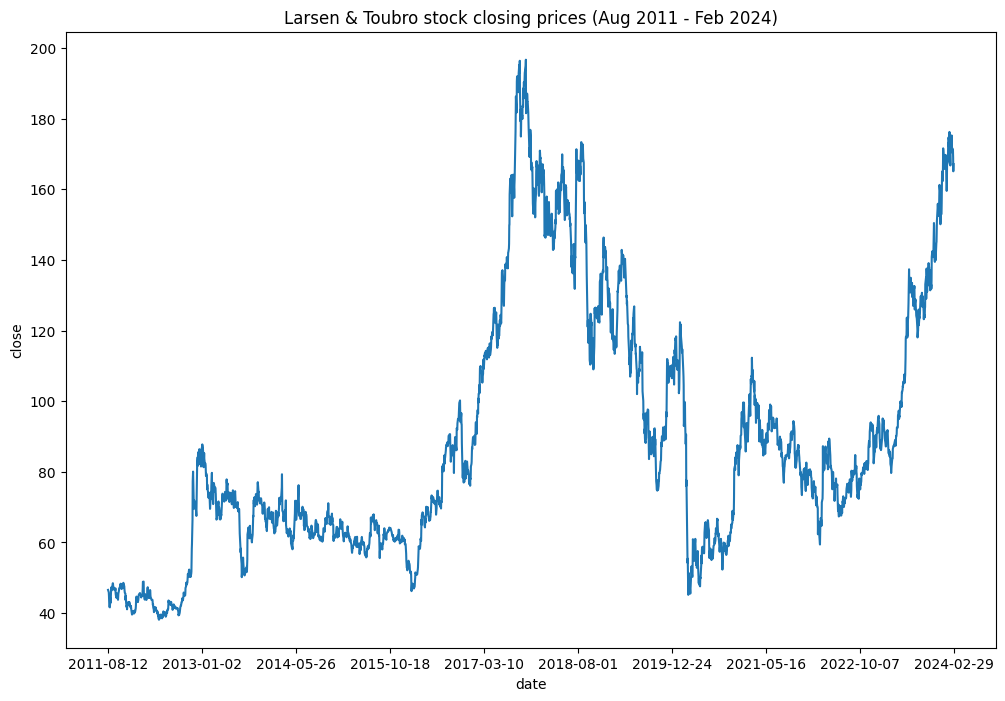

In [3]:
plt.figure(figsize= (12,8))
sns.lineplot(data= df, x= 'date', y= 'close')
plt.xticks([str(x) for x in list(pd.date_range(start= df.date.min(), end= df.date.max(), periods= 10))])
plt.title("Larsen & Toubro stock closing prices (Aug 2011 - Feb 2024)")
plt.show()

In [4]:
def calculate_moving_averages(data, periods=[10, 20]):
    """
    Calculate Simple and Exponential Moving Averages for given periods.

    Parameters:
    - data: DataFrame containing the stock data.
    - periods: List of periods for which to calculate the moving averages.

    Returns:
    - DataFrame with additional columns for each SMA and EMA calculated.
    """
    for period in periods:
        # Simple Moving Average
        sma_column_name = f'SMA_{period}'
        data[sma_column_name] = data['close'].rolling(window=period).mean()

        # Exponential Moving Average
        ema_column_name = f'EMA_{period}'
        data[ema_column_name] = data['close'].ewm(span=period, adjust=False).mean()

    return data

In [5]:
df = calculate_moving_averages(df, periods=[10, 20])

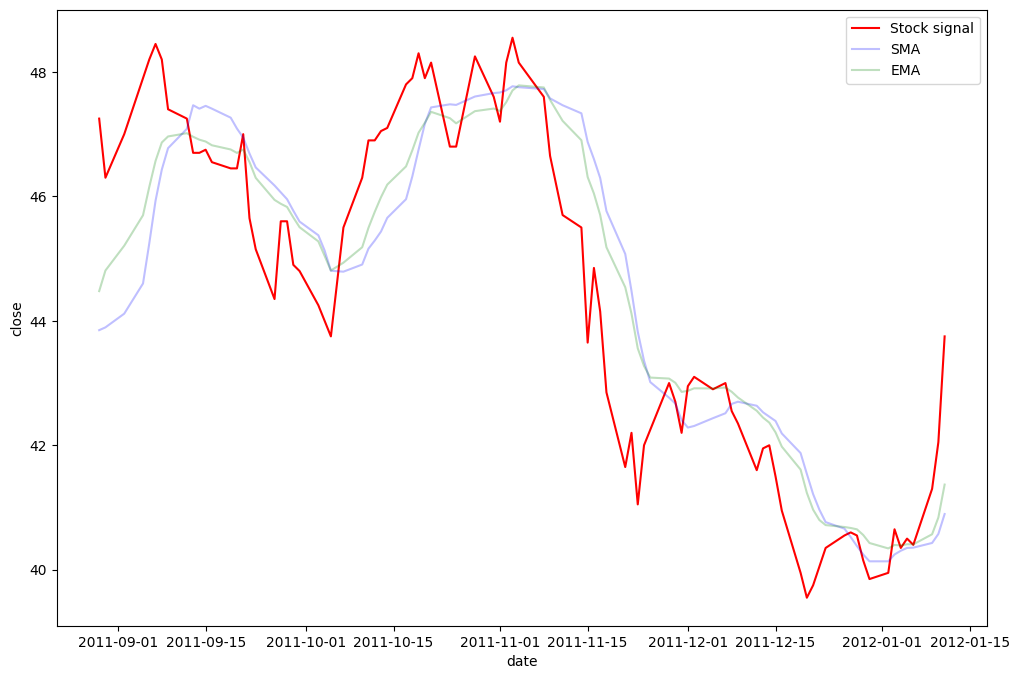

In [6]:
plt.figure(figsize= (12,8))
# sns.lineplot(data= df, x= 'date', y= 'open')
sns.lineplot(data= df.iloc[10:100], x= 'date', y= 'close', color= 'red',  label= 'Stock signal')
sns.lineplot(data= df.iloc[10:100], x= 'date', y= 'SMA_10', color= 'blue', alpha= 0.25, label= 'SMA')
sns.lineplot(data= df.iloc[10:100], x= 'date', y= 'EMA_10', color= 'green', alpha= 0.25, label= 'EMA')
# plt.xticks([str(x) for x in list(pd.date_range(start= df.date.min(), end= df.date.max(), periods= 10))])
plt.legend()
plt.show()

In [7]:
def add_momentum_indicators(data):
    """
    Add momentum indicators (RSI and MACD) to the DataFrame.

    Parameters:
    - data: DataFrame containing the stock OHLC data.

    Returns:
    - DataFrame with additional columns for RSI and MACD.
    """
    # Calculate RSI
    data['RSI'] = ta.momentum.RSIIndicator(data['close'], window=14).rsi()
    
    # Calculate MACD
    macd = ta.trend.MACD(data['close'])
    data['MACD'] = macd.macd()
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_diff'] = macd.macd_diff()  # MACD histogram
    
    return data

In [8]:
df = add_momentum_indicators(df)

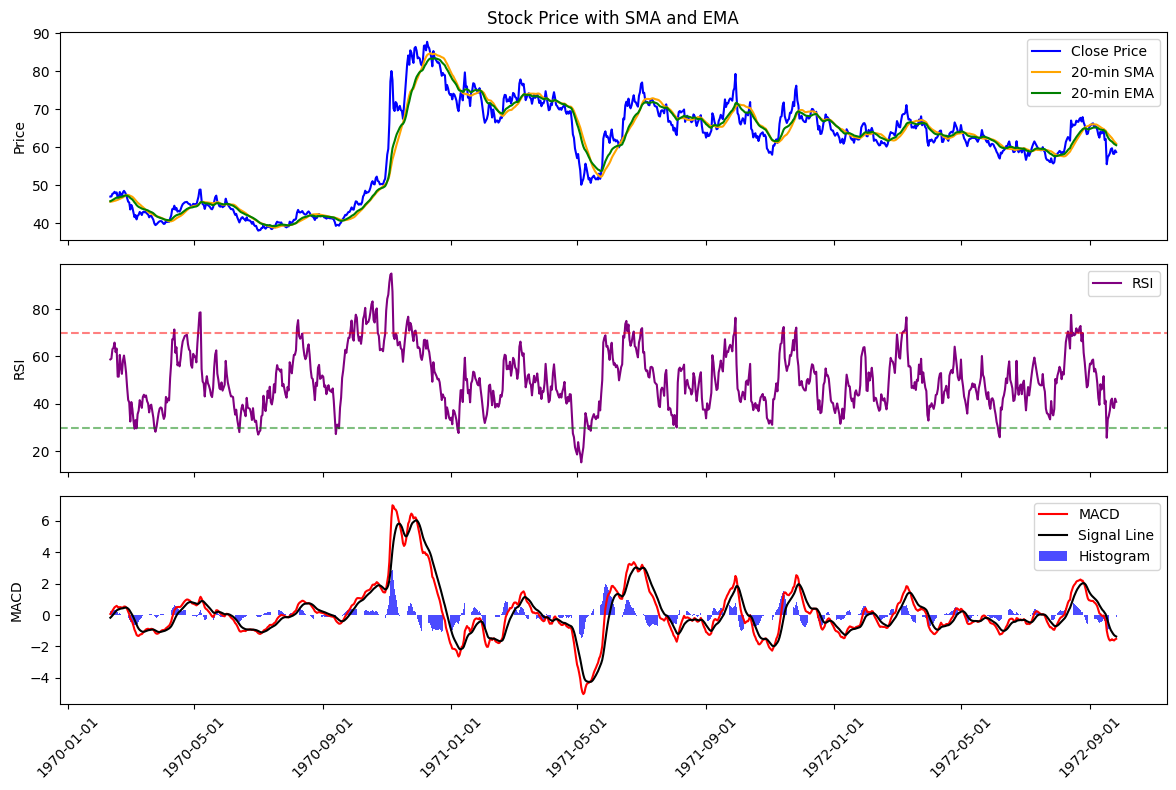

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
data = df.iloc[40:1000]
# Convert date column to datetime
# data['date'] = pd.to_datetime(data['date'])
# data.set_index('date', inplace=True)

# Plotting the closing price, SMA, and EMA on the first subplot
ax1.plot(data.index, data['close'], label='Close Price', color='blue')
if 'SMA_20' in data.columns:
    ax1.plot(data.index, data['SMA_20'], label='20-min SMA', color='orange')
if 'EMA_20' in data.columns:
    ax1.plot(data.index, data['EMA_20'], label='20-min EMA', color='green')
ax1.legend(loc='best')
ax1.set_ylabel('Price')
ax1.set_title('Stock Price with SMA and EMA')

# Plotting RSI on the second subplot
if 'RSI' in data.columns:
    ax2.plot(data.index, data['RSI'], label='RSI', color='purple')
    ax2.axhline(70, linestyle='--', color='red', alpha=0.5)  # Overbought line
    ax2.axhline(30, linestyle='--', color='green', alpha=0.5)  # Oversold line
    ax2.set_ylabel('RSI')
    ax2.legend(loc='best')

# Plotting MACD on the third subplot
if 'MACD' in data.columns and 'MACD_signal' in data.columns:
    ax3.plot(data.index, data['MACD'], label='MACD', color='red')
    ax3.plot(data.index, data['MACD_signal'], label='Signal Line', color='black')
    # Plotting MACD histogram (bar chart)
    ax3.bar(data.index, data['MACD_diff'], label='Histogram', color='blue', alpha=0.7, width=0.7)
    ax3.legend(loc='best')
    ax3.set_ylabel('MACD')

# Formatting the x-axis to show dates nicely
ax3.xaxis.set_major_locator(mdates.AutoDateLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
def add_volatility_indicators(data):
    """
    Add volatility indicators (ATR, Bollinger Bands) to the DataFrame.

    Parameters:
    - data: DataFrame containing the stock OHLC data.

    Returns:
    - DataFrame with additional columns for ATR and Bollinger Bands.
    """
    # Calculate Average True Range (ATR)
    data['ATR'] = ta.volatility.AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()

    # Calculate Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['close'], window=20, window_dev=2)
    data['bollinger_mavg'] = bollinger.bollinger_mavg()
    data['bollinger_hband'] = bollinger.bollinger_hband()
    data['bollinger_lband'] = bollinger.bollinger_lband()
    
    return data

In [11]:
df = add_volatility_indicators(df)

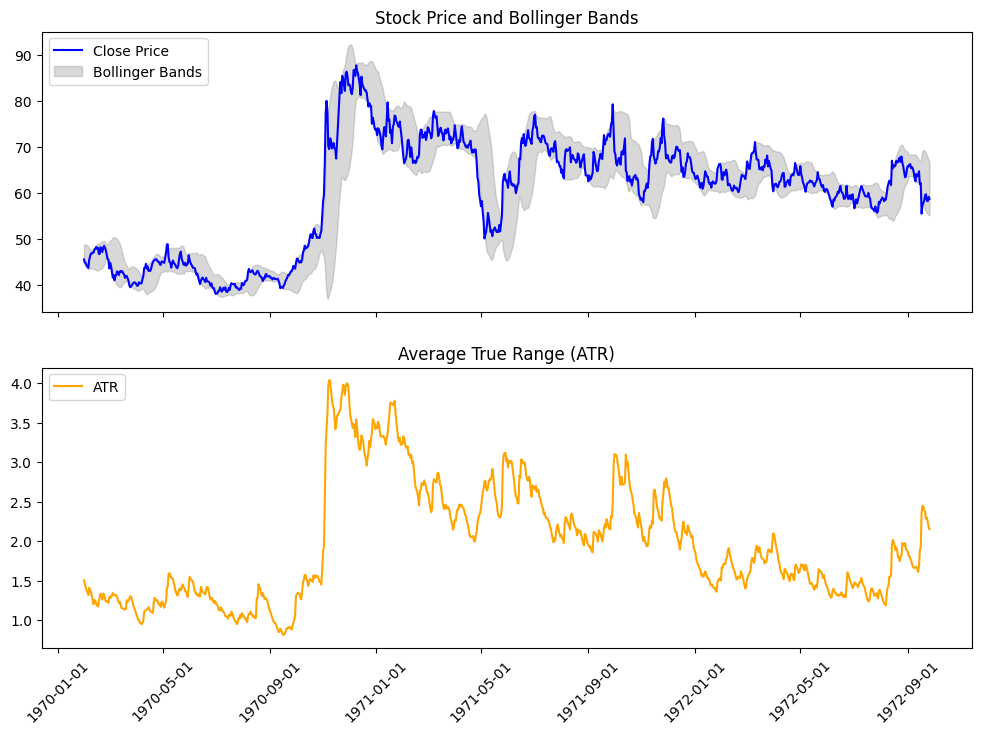

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
data = df.iloc[30:1000]
# Plot closing price and Bollinger Bands
ax1.plot(data.index, data['close'], label='Close Price', color='blue')
ax1.fill_between(data.index, data['bollinger_hband'], data['bollinger_lband'], color='grey', alpha=0.3, label='Bollinger Bands')
ax1.legend(loc='upper left')
ax1.set_title('Stock Price and Bollinger Bands')

# Plot ATR
ax2.plot(data.index, data['ATR'], label='ATR', color='orange')
ax2.legend(loc='upper left')
ax2.set_title('Average True Range (ATR)')

# Improve the x-axis with date formatting
ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.show()

In [13]:
def add_volume_indicators(data, short_window=5, long_window=20):
    """
    Add volume indicators (OBV, Volume Oscillator) to the DataFrame.

    Parameters:
    - data: DataFrame containing the stock OHLC data and volume.

    Returns:
    - DataFrame with additional columns for OBV and Volume Oscillator.
    """
    # Calculate On-Balance Volume (OBV)
    data['OBV'] = ta.volume.OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    
    # Calculate Volume Oscillator
    # Note: 'window_slow' and 'window_fast' can be adjusted as needed
    # Short-term and Long-term Moving Averages of the volume
    short_vol_MA = data['volume'].rolling(window=short_window).mean()
    long_vol_MA = data['volume'].rolling(window=long_window).mean()
    
    # Volume Oscillator calculation
    data['vol_osc'] = short_vol_MA - long_vol_MA

    return data

In [14]:
df = add_volume_indicators(df)

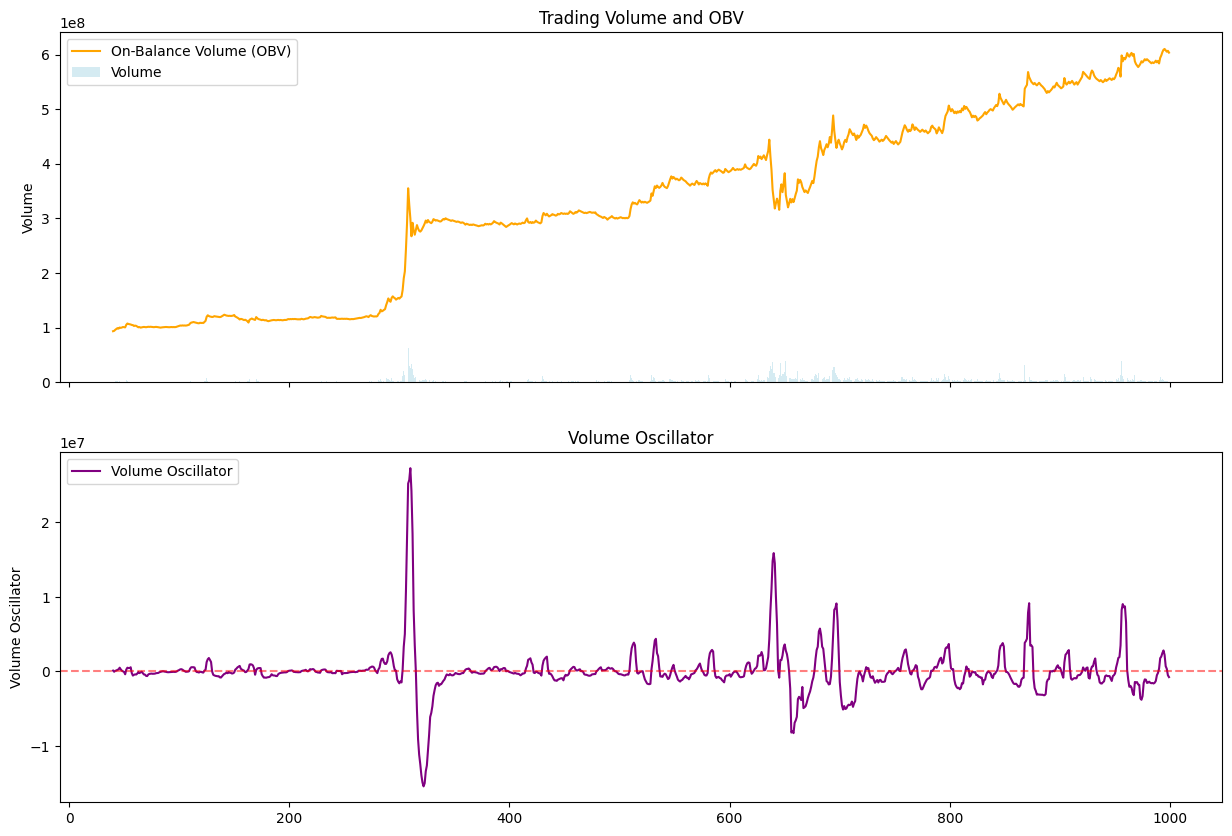

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
data = df.iloc[40:1000]
# Plotting the volume and OBV
ax1.bar(data.index, data['volume'], label='Volume', color='lightblue', alpha=0.5)
ax1.plot(data.index, data['OBV'], label='On-Balance Volume (OBV)', color='orange')
ax1.legend(loc='upper left')
ax1.set_ylabel('Volume')
ax1.set_title('Trading Volume and OBV')

# Plotting the Volume Oscillator
ax2.plot(data.index, data['vol_osc'], label='Volume Oscillator', color='purple')
ax2.axhline(0, linestyle='--', color='red', alpha=0.5)  # Zero line for reference
ax2.legend(loc='upper left')
ax2.set_ylabel('Volume Oscillator')
ax2.set_title('Volume Oscillator')

plt.show()

In [16]:
def add_stochastic_oscillator(data):
    """
    Add Stochastic Oscillator to the DataFrame.

    Parameters:
    - data: DataFrame containing the stock OHLC data.

    Returns:
    - DataFrame with additional columns for Stochastic Oscillator (%K and %D).
    """
    # Initialize Stochastic Oscillator
    stochastic_osc = ta.momentum.StochasticOscillator(data['high'], data['low'], data['close'], window=14, smooth_window=3)
    
    # Calculate %K and %D lines
    data['stoch_%K'] = stochastic_osc.stoch()
    data['stoch_%D'] = stochastic_osc.stoch_signal()
    
    return data

In [17]:
df = add_stochastic_oscillator(df)

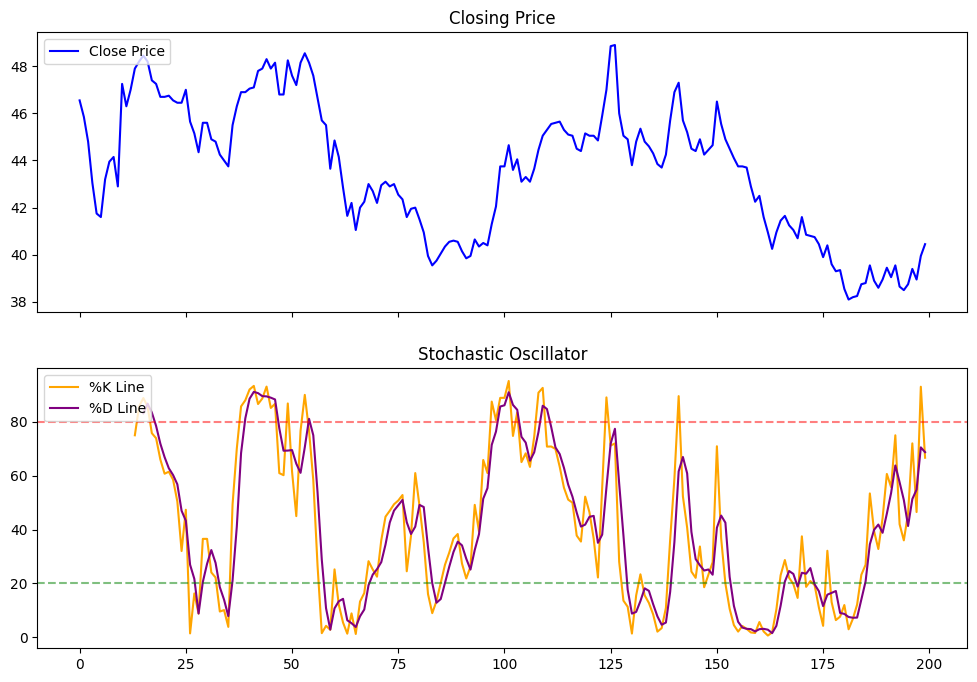

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
data = df.iloc[:200]    
# Plot the closing price
ax1.plot(data.index, data['close'], label='Close Price', color='blue')
ax1.set_title('Closing Price')
ax1.legend(loc='upper left')

# Plot the Stochastic Oscillator (%K and %D)
ax2.plot(data.index, data['stoch_%K'], label='%K Line', color='orange')
ax2.plot(data.index, data['stoch_%D'], label='%D Line', color='purple')
ax2.axhline(80, linestyle='--', color='red', alpha=0.5)  # Overbought line
ax2.axhline(20, linestyle='--', color='green', alpha=0.5)  # Oversold line
ax2.set_title('Stochastic Oscillator')
ax2.legend(loc='upper left')

plt.show()

In [19]:
data = df[['open', 'high', 'low', 'close', 'SMA_20', 'EMA_20', 'volume']]
data.dropna(inplace= True)
data.reset_index(inplace= True, drop= True)
data

,open,high,low,close,SMA_20,EMA_20,volume
0,47.80,47.95,46.60,46.70,45.6225,46.440211,1446917
1,47.25,47.25,46.60,46.70,45.6300,46.464952,793189
2,47.05,47.55,46.60,46.75,45.6750,46.492100,1028269
3,46.85,47.10,46.40,46.55,45.7625,46.497614,1059502
4,46.10,46.90,46.10,46.45,45.9325,46.493079,751077
...,...,...,...,...,...,...,...
3074,172.45,173.25,171.00,171.60,171.8925,171.066482,1386896
3075,171.90,173.45,170.65,171.05,172.0650,171.064912,2001242
3076,171.50,172.00,168.20,169.05,172.1275,170.873016,2333404
3077,170.05,172.20,164.05,165.10,171.7225,170.323205,3378066


In [20]:
Actions = [0,1,2] #0 buy, 1 hold, 2 sell

features = ['open', 'high', 'low', 'close', 'SMA_20', 'EMA_20']
data = df[features] # Specify the features to be normalized
data['date'] = df.date

history_length = 10

for feature in ['open', 'high', 'low', 'close']:
    for i in range(history_length):
        data[f'{feature}_t-{i}'] = data[feature].shift(i)

selected_features = [f'{feature}_t-{i}' for feature in ['open', 'high', 'low', 'close'] for i in range(history_length)] + ['SMA_20', 'EMA_20', 'date']
processed_data = data[selected_features].dropna()

offset = processed_data.date.min() + pd.DateOffset(years= 8, months = 8, days = 30)

train_data = processed_data[processed_data.date <= offset]
test_data = processed_data[processed_data.date > offset]

In [21]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer_1 = nn.Linear(state_dim, 256)
        self.layer_2 = nn.Linear(256, 512)
        self.layer_3 = nn.Linear(512, 256)
        self.layer_4 = nn.Linear(256, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.layer_1(state))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        x = F.softmax(self.layer_4(x), dim=-1) #self.max_action * torch.tanh(self.layer_3(x))
        return x

In [22]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        # Critic 1
        self.layer_1 = nn.Linear(state_dim + 1, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 1)
        
        # Critic 2
        self.layer_5 = nn.Linear(state_dim + 1, 128)
        self.layer_6 = nn.Linear(128, 256)
        self.layer_7 = nn.Linear(256, 128)
        self.layer_8 = nn.Linear(128, 1)

    def forward(self, state, action):
        if action.dim() == 1:
            action = action.view(-1, 1)

        sa = torch.cat([state, action], 1)
        
        # Critic 1
        q1 = F.relu(self.layer_1(sa))
        q1 = F.relu(self.layer_2(q1))
        q1 = F.relu(self.layer_3(q1))
        q1 = self.layer_4(q1)
        
        # Critic 2
        q2 = F.relu(self.layer_5(sa))
        q2 = F.relu(self.layer_6(q2))
        q2 = F.relu(self.layer_7(q2))
        q2 = self.layer_8(q2)
        
        return q1, q2

    def Q1(self, state, action):
        if action.dim() == 1:
            action = action.view(-1, 1)
        
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.layer_1(sa))
        q1 = F.relu(self.layer_2(q1))
        q1 = self.layer_3(q1)
        return q1

In [23]:
class ReplayBuffer:
    def __init__(self, max_size=1e6):
        self.storage = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.storage) == self.max_size:
            self.storage[int(self.ptr)] = transition
            self.ptr = (self.ptr + 1) % self.max_size
        else:
            self.storage.append(transition)

    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.storage), size=batch_size)
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
        
        for i in ind: 
            state, next_state, action, reward, done = self.storage[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))
        
        return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), \
               np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

In [24]:
class TD3:
    def __init__(self, state_dim, action_dim, max_action):
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters())

        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.critic_target_1 = copy.deepcopy(self.critic_1)
        self.critic_target_2 = copy.deepcopy(self.critic_2)
        self.critic_optimizer_1 = optim.Adam(self.critic_1.parameters())
        self.critic_optimizer_2 = optim.Adam(self.critic_2.parameters())

        self.max_action = max_action
        self.replay_buffer = ReplayBuffer()
        # Lists to store Q values for plotting
        self.q1_values = []
        self.q2_values = []
        self.last_mean_q1 = 0
        self.last_mean_q2 = 0
        self.it = 0
        self.convergence = False
        self.actor_losses = []
    
    def select_action(self, state, epsilon= 0.25):
        if np.random.rand() < epsilon:
            # With probability ε, select a random action
            return np.random.choice(range(int(max_action)+1))
        else:
            state = torch.FloatTensor(state.reshape(1, -1)).to(device)
            return np.argmax(self.actor(state).cpu().data.numpy().flatten())

    def train(self, batch_size=32, discount=0.9, tau=0.05, policy_freq=2,convergence_tol=0.001):

        # last_mean_q1, last_mean_q2 = 0, 0
        
        # for it in range(batch_size):
        # Sample replay buffer 
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(batch_states).to(device)
        next_state = torch.FloatTensor(batch_next_states).to(device)
        action = torch.FloatTensor(batch_actions).to(device)
        reward = torch.FloatTensor(batch_rewards).to(device)
        done = torch.FloatTensor(batch_dones).to(device)
        
        # Compute the target Q value
        action_probabilities = self.actor_target(next_state)
        next_action = torch.argmax(action_probabilities, dim=1, keepdim=True)
        
        # Clipped Double Q-learning
        target_Q1, target_Q2 = self.critic_target_1(next_state, next_action), self.critic_target_2(next_state, next_action)
        # print(target_Q1[0].size(), target_Q2)
        target_Q = torch.min(target_Q1[0], target_Q2[1])
        target_Q = reward + ((1 - done) * discount * target_Q).detach()
        
        # Get current Q estimates
        current_Q1, current_Q2 = self.critic_1(state, action), self.critic_2(state, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q1[0], target_Q) + F.mse_loss(current_Q2[1], target_Q)

        # Optimize the critics
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        critic_loss.backward()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()

        # Delayed policy updates
        if self.it % policy_freq == 0:
            # Compute actor loss
            actor_loss = -self.critic_1.Q1(state, torch.argmax(self.actor(state), dim=1, keepdim=True)).mean()
            
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.actor_losses.append(actor_loss.item())

            # Update the frozen target models
            for param, target_param in zip(self.critic_1.parameters(), self.critic_target_1.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.critic_2.parameters(), self.critic_target_2.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        # Convergence check based on the mean of the Q-values
        # print(current_Q2[1])
        mean_q1 = current_Q1[0].mean().item()
        mean_q2 = current_Q2[1].mean().item()
        self.q1_values.append(mean_q1)
        self.q2_values.append(mean_q2)

        if abs(mean_q1 - self.last_mean_q1) < convergence_tol and abs(mean_q2 - self.last_mean_q2) < convergence_tol:
            print(f"Convergence achieved")
            self.convergence = True
            

        self.last_mean_q1, self.last_mean_q2 = mean_q1, mean_q2
        self.it += 1

        return self.convergence

    def plot_q_values(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.q1_values, label='Q1 Values',alpha=0.75)
        plt.plot(self.q2_values, label='Q2 Values',alpha=0.5)
        plt.xlabel('Iteration')
        plt.ylabel('Q Value')
        plt.title('Q1 and Q2 Values Over Training Iterations')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actor_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.actor_losses, label='Actor Losses')
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('Actor Loss Over Training')
        plt.legend()
        plt.grid(True)
        plt.show()

In [27]:
device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = StandardScaler()
processed_train_data = pd.DataFrame(scaler.fit_transform(train_data.set_index('date')), columns= selected_features[:-1])
env = TradingEnv(processed_train_data, scaler)

initial_episodes= 1000
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
max_action = 2.0

td3_agent = TD3(state_dim, action_dim, max_action)

state = env.reset()
for _ in tqdm(range(initial_episodes), desc= "Storing replay episodes"):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    td3_agent.replay_buffer.add((state, next_state, action, reward, done))
    state = next_state if not done else env.reset()

total_episodes = 10000  # Modify based on your environment and requirements
for episode in tqdm(range(total_episodes), desc= "Training steps"):
    state = env.reset()
    episode_reward = 0
    done = False
    convergence_flag = False
    while not done:
        # pdb.set_trace()
        action = td3_agent.select_action(np.array(state))
        next_state, reward, done, _ = env.step(action)
        td3_agent.replay_buffer.add((state, next_state, action, reward, done))
        
        convergence_flag = td3_agent.train()
        state = next_state
        episode_reward += reward

        if convergence_flag:
            break

    if convergence_flag:
        break
    
    print(f"Episode: {episode + 1}, Reward: {episode_reward}")

Training steps:   0%|                                                                                                                                                       | 1/10000 [00:00<1:55:15,  1.45it/s]

Episode: 1, Reward: 572.63401598635


Training steps:   0%|                                                                                                                                                       | 2/10000 [00:01<2:01:20,  1.37it/s]

Episode: 2, Reward: 325.44151598635017


Training steps:   0%|                                                                                                                                                       | 3/10000 [00:02<2:02:09,  1.36it/s]

Episode: 3, Reward: 419.79000000000013


Training steps:   0%|                                                                                                                                                       | 4/10000 [00:02<2:01:13,  1.37it/s]

Episode: 4, Reward: 448.0324999999998


Training steps:   0%|                                                                                                                                                       | 5/10000 [00:03<2:00:26,  1.38it/s]

Episode: 5, Reward: 297.6493477971739


Training steps:   0%|                                                                                                                                                       | 6/10000 [00:04<1:58:56,  1.40it/s]

Episode: 6, Reward: 285.19500000000016


Training steps:   0%|                                                                                                                                                       | 7/10000 [00:05<2:00:17,  1.38it/s]

Episode: 7, Reward: 370.21509661649225


Training steps:   0%|                                                                                                                                                       | 8/10000 [00:05<1:57:56,  1.41it/s]

Episode: 8, Reward: 553.3399999999999


Training steps:   0%|▏                                                                                                                                                      | 9/10000 [00:06<1:54:47,  1.45it/s]

Episode: 9, Reward: 470.75249999999994


Training steps:   0%|▏                                                                                                                                                     | 10/10000 [00:07<1:58:05,  1.41it/s]

Episode: 10, Reward: 516.1850000000002


Training steps:   0%|▏                                                                                                                                                     | 11/10000 [00:07<1:58:23,  1.41it/s]

Episode: 11, Reward: 611.5350000000001


Training steps:   0%|▏                                                                                                                                                     | 12/10000 [00:08<1:59:04,  1.40it/s]

Episode: 12, Reward: 452.19750000000005


Training steps:   0%|▏                                                                                                                                                     | 13/10000 [00:09<2:04:18,  1.34it/s]

Episode: 13, Reward: 452.155


Training steps:   0%|▏                                                                                                                                                     | 14/10000 [00:10<2:10:42,  1.27it/s]

Episode: 14, Reward: 358.02661260284236


Training steps:   0%|▏                                                                                                                                                     | 15/10000 [00:11<2:12:17,  1.26it/s]

Episode: 15, Reward: 579.5389766552826


Training steps:   0%|▏                                                                                                                                                     | 16/10000 [00:11<2:09:39,  1.28it/s]

Episode: 16, Reward: 364.26999999999987


Training steps:   0%|▎                                                                                                                                                     | 17/10000 [00:12<2:09:22,  1.29it/s]

Episode: 17, Reward: 522.0474999999999


Training steps:   0%|▎                                                                                                                                                     | 18/10000 [00:13<2:09:58,  1.28it/s]

Episode: 18, Reward: 499.70557946110165


Training steps:   0%|▎                                                                                                                                                     | 19/10000 [00:14<2:11:56,  1.26it/s]

Episode: 19, Reward: 369.39434779717396


Training steps:   0%|▎                                                                                                                                                     | 20/10000 [00:15<2:12:38,  1.25it/s]

Episode: 20, Reward: 336.6399999999999


Training steps:   0%|▎                                                                                                                                                     | 21/10000 [00:15<2:12:39,  1.25it/s]

Episode: 21, Reward: 524.2265541550703


Training steps:   0%|▎                                                                                                                                                     | 22/10000 [00:16<2:14:41,  1.23it/s]

Episode: 22, Reward: 511.97434779717383


Training steps:   0%|▎                                                                                                                                                     | 23/10000 [00:17<2:18:21,  1.20it/s]

Episode: 23, Reward: 350.8349999999999


Training steps:   0%|▎                                                                                                                                                     | 24/10000 [00:18<2:15:18,  1.23it/s]

Episode: 24, Reward: 429.89307014142054


Training steps:   0%|▍                                                                                                                                                     | 25/10000 [00:19<2:17:44,  1.21it/s]

Episode: 25, Reward: 145.36500000000024


Training steps:   0%|▍                                                                                                                                                     | 26/10000 [00:20<2:18:32,  1.20it/s]

Episode: 26, Reward: 516.655


Training steps:   0%|▍                                                                                                                                                     | 27/10000 [00:20<2:22:06,  1.17it/s]

Episode: 27, Reward: 316.74342106894846


Training steps:   0%|▍                                                                                                                                                     | 28/10000 [00:21<2:22:48,  1.16it/s]

Episode: 28, Reward: 307.8949999999999


Training steps:   0%|▍                                                                                                                                                     | 29/10000 [00:22<2:23:22,  1.16it/s]

Episode: 29, Reward: 364.3180794611019


Training steps:   0%|▍                                                                                                                                                     | 30/10000 [00:23<2:23:55,  1.15it/s]

Episode: 30, Reward: 513.9499999999999


Training steps:   0%|▍                                                                                                                                                     | 31/10000 [00:24<2:27:08,  1.13it/s]

Episode: 31, Reward: 428.0565541550704


Training steps:   0%|▍                                                                                                                                                     | 32/10000 [00:25<2:27:14,  1.13it/s]

Episode: 32, Reward: 212.03500000000003


Training steps:   0%|▍                                                                                                                                                     | 33/10000 [00:26<2:26:17,  1.14it/s]

Episode: 33, Reward: 185.7519444136662


Training steps:   0%|▌                                                                                                                                                     | 34/10000 [00:27<2:24:46,  1.15it/s]

Episode: 34, Reward: 307.355


Training steps:   0%|▌                                                                                                                                                     | 35/10000 [00:28<2:28:24,  1.12it/s]

Episode: 35, Reward: 669.7


Training steps:   0%|▌                                                                                                                                                     | 36/10000 [00:29<2:37:03,  1.06it/s]

Episode: 36, Reward: 674.0


Training steps:   0%|▌                                                                                                                                                     | 37/10000 [00:30<2:38:07,  1.05it/s]

Episode: 37, Reward: 509.6400000000001


Training steps:   0%|▌                                                                                                                                                     | 38/10000 [00:30<2:32:49,  1.09it/s]

Episode: 38, Reward: 327.7349999999999


Training steps:   0%|▌                                                                                                                                                     | 39/10000 [00:31<2:28:56,  1.11it/s]

Episode: 39, Reward: 507.1725


Training steps:   0%|▌                                                                                                                                                     | 40/10000 [00:32<2:30:59,  1.10it/s]

Episode: 40, Reward: -32.253445844929615


Training steps:   0%|▌                                                                                                                                                     | 41/10000 [00:33<2:28:33,  1.12it/s]

Episode: 41, Reward: 545.4025000000001


Training steps:   0%|▋                                                                                                                                                     | 42/10000 [00:34<2:29:46,  1.11it/s]

Episode: 42, Reward: 524.0649999999998


Training steps:   0%|▋                                                                                                                                                     | 43/10000 [00:35<2:34:48,  1.07it/s]

Episode: 43, Reward: 309.0250000000001


Training steps:   0%|▋                                                                                                                                                     | 44/10000 [00:36<2:34:44,  1.07it/s]

Episode: 44, Reward: 517.6324999999999


Training steps:   0%|▋                                                                                                                                                     | 45/10000 [00:37<2:40:29,  1.03it/s]

Episode: 45, Reward: 351.40336378352396


Training steps:   0%|▋                                                                                                                                                     | 46/10000 [00:38<2:51:49,  1.04s/it]

Episode: 46, Reward: 631.2130794611018


Training steps:   0%|▋                                                                                                                                                     | 47/10000 [00:39<2:52:26,  1.04s/it]

Episode: 47, Reward: 572.3950000000001


Training steps:   0%|▋                                                                                                                                                     | 48/10000 [00:40<2:50:05,  1.03s/it]

Episode: 48, Reward: 505.14009661649226


Training steps:   0%|▋                                                                                                                                                     | 49/10000 [00:41<2:53:33,  1.05s/it]

Episode: 49, Reward: 550.7000000000002


Training steps:   0%|▊                                                                                                                                                     | 50/10000 [00:42<2:47:48,  1.01s/it]

Episode: 50, Reward: 542.2000000000002


Training steps:   1%|▊                                                                                                                                                     | 51/10000 [00:43<2:46:38,  1.00s/it]

Episode: 51, Reward: 569.6475


Training steps:   1%|▊                                                                                                                                                     | 52/10000 [00:44<2:39:30,  1.04it/s]

Episode: 52, Reward: 572.0324999999999


Training steps:   1%|▊                                                                                                                                                     | 53/10000 [00:45<2:39:57,  1.04it/s]

Episode: 53, Reward: 480.3575000000001


Training steps:   1%|▊                                                                                                                                                     | 54/10000 [00:46<2:43:42,  1.01it/s]

Episode: 54, Reward: 395.26499999999993


Training steps:   1%|▊                                                                                                                                                     | 55/10000 [00:47<2:38:00,  1.05it/s]

Episode: 55, Reward: 296.31250000000006


Training steps:   1%|▊                                                                                                                                                     | 56/10000 [00:48<2:38:43,  1.04it/s]

Episode: 56, Reward: 589.4064766552825


Training steps:   1%|▊                                                                                                                                                     | 57/10000 [00:49<2:33:46,  1.08it/s]

Episode: 57, Reward: 451.2293477971739


Training steps:   1%|▊                                                                                                                                                     | 58/10000 [00:50<2:38:24,  1.05it/s]

Episode: 58, Reward: 287.6200966164923


Training steps:   1%|▉                                                                                                                                                     | 59/10000 [00:51<2:37:39,  1.05it/s]

Episode: 59, Reward: 344.0430794611017


Training steps:   1%|▉                                                                                                                                                     | 60/10000 [00:52<2:39:26,  1.04it/s]

Episode: 60, Reward: 568.715


Training steps:   1%|▉                                                                                                                                                     | 61/10000 [00:53<2:35:29,  1.07it/s]

Episode: 61, Reward: 357.42655415507033


Training steps:   1%|▉                                                                                                                                                     | 62/10000 [00:54<2:36:07,  1.06it/s]

Episode: 62, Reward: 550.3799999999999


Training steps:   1%|▉                                                                                                                                                     | 63/10000 [00:54<2:35:12,  1.07it/s]

Episode: 63, Reward: 552.3025


Training steps:   1%|▉                                                                                                                                                     | 64/10000 [00:55<2:33:13,  1.08it/s]

Episode: 64, Reward: 502.1500000000001


Training steps:   1%|▉                                                                                                                                                     | 65/10000 [00:56<2:32:56,  1.08it/s]

Episode: 65, Reward: 541.6889766552824


Training steps:   1%|▉                                                                                                                                                     | 66/10000 [00:57<2:32:45,  1.08it/s]

Episode: 66, Reward: 395.3780794611018


Training steps:   1%|█                                                                                                                                                     | 67/10000 [00:58<2:30:38,  1.10it/s]

Episode: 67, Reward: 294.3118477971739


Training steps:   1%|█                                                                                                                                                     | 68/10000 [00:59<2:30:37,  1.10it/s]

Episode: 68, Reward: 636.4625000000001


Training steps:   1%|█                                                                                                                                                     | 69/10000 [01:00<2:40:16,  1.03it/s]

Episode: 69, Reward: 681.8


Training steps:   1%|█                                                                                                                                                     | 70/10000 [01:01<2:42:04,  1.02it/s]

Episode: 70, Reward: 354.4400966164923


Training steps:   1%|█                                                                                                                                                     | 71/10000 [01:02<2:42:06,  1.02it/s]

Episode: 71, Reward: 569.5225


Training steps:   1%|█                                                                                                                                                     | 72/10000 [01:03<2:41:39,  1.02it/s]

Episode: 72, Reward: 267.06250000000006


Training steps:   1%|█                                                                                                                                                     | 73/10000 [01:04<2:39:46,  1.04it/s]

Episode: 73, Reward: 542.9890541550703


Training steps:   1%|█                                                                                                                                                     | 74/10000 [01:05<2:38:42,  1.04it/s]

Episode: 74, Reward: 454.0925000000001


Training steps:   1%|█▏                                                                                                                                                    | 75/10000 [01:06<2:38:29,  1.04it/s]

Episode: 75, Reward: 498.88901598635005


Training steps:   1%|█▏                                                                                                                                                    | 76/10000 [01:07<2:38:04,  1.05it/s]

Episode: 76, Reward: 520.1414766552826


Training steps:   1%|█▏                                                                                                                                                    | 77/10000 [01:08<2:32:47,  1.08it/s]

Episode: 77, Reward: 465.5875


Training steps:   1%|█▏                                                                                                                                                    | 78/10000 [01:09<2:29:08,  1.11it/s]

Episode: 78, Reward: 524.9939766552825


Training steps:   1%|█▏                                                                                                                                                    | 79/10000 [01:09<2:26:32,  1.13it/s]

Episode: 79, Reward: 447.7904926416325


Training steps:   1%|█▏                                                                                                                                                    | 80/10000 [01:10<2:29:12,  1.11it/s]

Episode: 80, Reward: 406.52147665528236


Training steps:   1%|█▏                                                                                                                                                    | 81/10000 [01:11<2:27:03,  1.12it/s]

Episode: 81, Reward: 410.65062742684506


Training steps:   1%|█▏                                                                                                                                                    | 82/10000 [01:12<2:25:05,  1.14it/s]

Episode: 82, Reward: 570.3500000000001


Training steps:   1%|█▏                                                                                                                                                    | 83/10000 [01:13<2:23:27,  1.15it/s]

Episode: 83, Reward: 257.34


Training steps:   1%|█▎                                                                                                                                                    | 84/10000 [01:14<2:22:17,  1.16it/s]

Episode: 84, Reward: 436.57750000000016


Training steps:   1%|█▎                                                                                                                                                    | 85/10000 [01:15<2:21:44,  1.17it/s]

Episode: 85, Reward: 573.3939766552824


Training steps:   1%|█▎                                                                                                                                                    | 86/10000 [01:15<2:20:49,  1.17it/s]

Episode: 86, Reward: 521.9174999999999


Training steps:   1%|█▎                                                                                                                                                    | 87/10000 [01:16<2:21:43,  1.17it/s]

Episode: 87, Reward: 436.46492725827557


Training steps:   1%|█▎                                                                                                                                                    | 88/10000 [01:17<2:21:33,  1.17it/s]

Episode: 88, Reward: 522.8


Training steps:   1%|█▎                                                                                                                                                    | 89/10000 [01:18<2:21:25,  1.17it/s]

Episode: 89, Reward: 513.1800000000001


Training steps:   1%|█▎                                                                                                                                                    | 90/10000 [01:19<2:20:38,  1.17it/s]

Episode: 90, Reward: 617.755


Training steps:   1%|█▎                                                                                                                                                    | 91/10000 [01:20<2:21:01,  1.17it/s]

Episode: 91, Reward: 461.8025000000001


Training steps:   1%|█▍                                                                                                                                                    | 92/10000 [01:21<2:21:04,  1.17it/s]

Episode: 92, Reward: 304.9830794611018


Training steps:   1%|█▍                                                                                                                                                    | 93/10000 [01:21<2:21:05,  1.17it/s]

Episode: 93, Reward: 375.2825


Training steps:   1%|█▍                                                                                                                                                    | 94/10000 [01:22<2:20:50,  1.17it/s]

Episode: 94, Reward: 206.11655415507016


Training steps:   1%|█▍                                                                                                                                                    | 95/10000 [01:23<2:21:10,  1.17it/s]

Episode: 95, Reward: 533.8799999999999


Training steps:   1%|█▍                                                                                                                                                    | 96/10000 [01:24<2:19:55,  1.18it/s]

Episode: 96, Reward: 366.4950000000001


Training steps:   1%|█▍                                                                                                                                                    | 97/10000 [01:25<2:20:45,  1.17it/s]

Episode: 97, Reward: 577.1675


Training steps:   1%|█▍                                                                                                                                                    | 98/10000 [01:26<2:20:40,  1.17it/s]

Episode: 98, Reward: 347.7664766552826


Training steps:   1%|█▍                                                                                                                                                    | 99/10000 [01:27<2:20:42,  1.17it/s]

Episode: 99, Reward: 595.2625966164923


Training steps:   1%|█▍                                                                                                                                                   | 100/10000 [01:27<2:19:35,  1.18it/s]

Episode: 100, Reward: 342.11250000000007


Training steps:   1%|█▌                                                                                                                                                   | 101/10000 [01:28<2:19:46,  1.18it/s]

Episode: 101, Reward: 645.4890541550703


Training steps:   1%|█▌                                                                                                                                                   | 102/10000 [01:29<2:19:53,  1.18it/s]

Episode: 102, Reward: 485.54000000000013


Training steps:   1%|█▌                                                                                                                                                   | 103/10000 [01:30<2:19:59,  1.18it/s]

Episode: 103, Reward: 484.23499999999996


Training steps:   1%|█▌                                                                                                                                                   | 104/10000 [01:31<2:20:16,  1.18it/s]

Episode: 104, Reward: 452.33


Training steps:   1%|█▌                                                                                                                                                   | 105/10000 [01:32<2:19:30,  1.18it/s]

Episode: 105, Reward: 485.13249999999994


Training steps:   1%|█▌                                                                                                                                                   | 106/10000 [01:32<2:19:11,  1.18it/s]

Episode: 106, Reward: 586.365


Training steps:   1%|█▌                                                                                                                                                   | 107/10000 [01:33<2:19:28,  1.18it/s]

Episode: 107, Reward: 635.5999999999999


Training steps:   1%|█▌                                                                                                                                                   | 108/10000 [01:34<2:19:38,  1.18it/s]

Episode: 108, Reward: 369.7215159863502


Training steps:   1%|█▌                                                                                                                                                   | 109/10000 [01:35<2:20:16,  1.18it/s]

Episode: 109, Reward: 493.3815159863501


Training steps:   1%|█▋                                                                                                                                                   | 110/10000 [01:36<2:19:13,  1.18it/s]

Episode: 110, Reward: 447.79999999999995


Training steps:   1%|█▋                                                                                                                                                   | 111/10000 [01:37<2:19:58,  1.18it/s]

Episode: 111, Reward: 365.5300000000001


Training steps:   1%|█▋                                                                                                                                                   | 112/10000 [01:38<2:20:29,  1.17it/s]

Episode: 112, Reward: 648.31


Training steps:   1%|█▋                                                                                                                                                   | 113/10000 [01:38<2:20:07,  1.18it/s]

Episode: 113, Reward: 622.0


Training steps:   1%|█▋                                                                                                                                                   | 114/10000 [01:39<2:19:20,  1.18it/s]

Episode: 114, Reward: 467.22499999999997


Training steps:   1%|█▋                                                                                                                                                   | 115/10000 [01:40<2:20:02,  1.18it/s]

Episode: 115, Reward: 392.04000000000013


Training steps:   1%|█▋                                                                                                                                                   | 116/10000 [01:41<2:21:00,  1.17it/s]

Episode: 116, Reward: 579.94


Training steps:   1%|█▋                                                                                                                                                   | 117/10000 [01:42<2:22:39,  1.15it/s]

Episode: 117, Reward: 511.04655415507034


Training steps:   1%|█▊                                                                                                                                                   | 118/10000 [01:43<2:21:21,  1.17it/s]

Episode: 118, Reward: 441.6325000000002


Training steps:   1%|█▊                                                                                                                                                   | 119/10000 [01:44<2:23:09,  1.15it/s]

Episode: 119, Reward: 555.5799999999999


Training steps:   1%|█▊                                                                                                                                                   | 120/10000 [01:45<2:25:54,  1.13it/s]

Episode: 120, Reward: 627.4725000000001


Training steps:   1%|█▊                                                                                                                                                   | 121/10000 [01:45<2:27:32,  1.12it/s]

Episode: 121, Reward: 517.5850966164924


Training steps:   1%|█▊                                                                                                                                                   | 122/10000 [01:46<2:26:30,  1.12it/s]

Episode: 122, Reward: 507.22151598635


Training steps:   1%|█▊                                                                                                                                                   | 123/10000 [01:47<2:25:16,  1.13it/s]

Episode: 123, Reward: 389.80907327177476


Training steps:   1%|█▊                                                                                                                                                   | 124/10000 [01:48<2:23:52,  1.14it/s]

Episode: 124, Reward: 421.38499999999993


Training steps:   1%|█▊                                                                                                                                                   | 125/10000 [01:49<2:22:55,  1.15it/s]

Episode: 125, Reward: 312.1205308103528


Training steps:   1%|█▉                                                                                                                                                   | 126/10000 [01:50<2:22:00,  1.16it/s]

Episode: 126, Reward: 300.3218477971739


Training steps:   1%|█▉                                                                                                                                                   | 127/10000 [01:51<2:22:19,  1.16it/s]

Episode: 127, Reward: 228.2205794611018


Training steps:   1%|█▉                                                                                                                                                   | 128/10000 [01:51<2:21:05,  1.17it/s]

Episode: 128, Reward: 238.875


Training steps:   1%|█▉                                                                                                                                                   | 129/10000 [01:52<2:21:03,  1.17it/s]

Episode: 129, Reward: 504.19259661649227


Training steps:   1%|█▉                                                                                                                                                   | 130/10000 [01:53<2:21:19,  1.16it/s]

Episode: 130, Reward: 260.2897302326645


Training steps:   1%|█▉                                                                                                                                                   | 131/10000 [01:54<2:21:05,  1.17it/s]

Episode: 131, Reward: 320.7775966164923


Training steps:   1%|█▉                                                                                                                                                   | 132/10000 [01:55<2:19:28,  1.18it/s]

Episode: 132, Reward: 264.56509661649227


Training steps:   1%|█▉                                                                                                                                                   | 133/10000 [01:56<2:19:33,  1.18it/s]

Episode: 133, Reward: 462.16655415507034


Training steps:   1%|█▉                                                                                                                                                   | 134/10000 [01:57<2:21:05,  1.17it/s]

Episode: 134, Reward: 565.7508244524563


Training steps:   1%|██                                                                                                                                                   | 135/10000 [01:57<2:21:39,  1.16it/s]

Episode: 135, Reward: 324.6640159863501


Training steps:   1%|██                                                                                                                                                   | 136/10000 [01:58<2:25:16,  1.13it/s]

Episode: 136, Reward: 322.5225


Training steps:   1%|██                                                                                                                                                   | 137/10000 [01:59<2:23:19,  1.15it/s]

Episode: 137, Reward: 593.7368477971738


Training steps:   1%|██                                                                                                                                                   | 138/10000 [02:00<2:21:45,  1.16it/s]

Episode: 138, Reward: 349.10000000000014


Training steps:   1%|██                                                                                                                                                   | 139/10000 [02:01<2:21:07,  1.16it/s]

Episode: 139, Reward: 354.2970954474518


Training steps:   1%|██                                                                                                                                                   | 140/10000 [02:02<2:21:11,  1.16it/s]

Episode: 140, Reward: 510.52750000000003


Training steps:   1%|██                                                                                                                                                   | 141/10000 [02:03<2:20:42,  1.17it/s]

Episode: 141, Reward: 424.4940541550702


Training steps:   1%|██                                                                                                                                                   | 142/10000 [02:03<2:20:22,  1.17it/s]

Episode: 142, Reward: 636.8900966164922


Training steps:   1%|██▏                                                                                                                                                  | 143/10000 [02:04<2:20:39,  1.17it/s]

Episode: 143, Reward: 494.90250000000003


Training steps:   1%|██▏                                                                                                                                                  | 144/10000 [02:05<2:20:04,  1.17it/s]

Episode: 144, Reward: 461.9839766552824


Training steps:   1%|██▏                                                                                                                                                  | 145/10000 [02:06<2:19:40,  1.18it/s]

Episode: 145, Reward: 569.5124999999999


Training steps:   1%|██▏                                                                                                                                                  | 146/10000 [02:07<2:22:07,  1.16it/s]

Episode: 146, Reward: 512.7325


Training steps:   1%|██▏                                                                                                                                                  | 147/10000 [02:08<2:22:50,  1.15it/s]

Episode: 147, Reward: 413.7365541550704


Training steps:   1%|██▏                                                                                                                                                  | 148/10000 [02:09<2:24:29,  1.14it/s]

Episode: 148, Reward: 187.4468477971742


Training steps:   1%|██▏                                                                                                                                                  | 149/10000 [02:10<2:23:24,  1.14it/s]

Episode: 149, Reward: 424.67307014142034


Training steps:   2%|██▏                                                                                                                                                  | 150/10000 [02:10<2:23:12,  1.15it/s]

Episode: 150, Reward: 460.314347797174


Training steps:   2%|██▏                                                                                                                                                  | 151/10000 [02:11<2:23:17,  1.15it/s]

Episode: 151, Reward: 433.34749999999985


Training steps:   2%|██▎                                                                                                                                                  | 152/10000 [02:12<2:21:52,  1.16it/s]

Episode: 152, Reward: 275.4624999999999


Training steps:   2%|██▎                                                                                                                                                  | 153/10000 [02:13<2:20:48,  1.17it/s]

Episode: 153, Reward: 519.8100000000002


Training steps:   2%|██▎                                                                                                                                                  | 154/10000 [02:14<2:19:55,  1.17it/s]

Episode: 154, Reward: 414.66155415507046


Training steps:   2%|██▎                                                                                                                                                  | 155/10000 [02:15<2:20:05,  1.17it/s]

Episode: 155, Reward: 320.2039766552825


Training steps:   2%|██▎                                                                                                                                                  | 156/10000 [02:16<2:19:45,  1.17it/s]

Episode: 156, Reward: 446.80509661649234


Training steps:   2%|██▎                                                                                                                                                  | 157/10000 [02:16<2:19:52,  1.17it/s]

Episode: 157, Reward: 497.45759661649225


Training steps:   2%|██▎                                                                                                                                                  | 158/10000 [02:17<2:20:01,  1.17it/s]

Episode: 158, Reward: 513.2624999999999


Training steps:   2%|██▎                                                                                                                                                  | 159/10000 [02:18<2:19:01,  1.18it/s]

Episode: 159, Reward: 453.57647665528236


Training steps:   2%|██▍                                                                                                                                                  | 160/10000 [02:19<2:18:51,  1.18it/s]

Episode: 160, Reward: 363.0305794611018


Training steps:   2%|██▍                                                                                                                                                  | 161/10000 [02:20<2:18:29,  1.18it/s]

Episode: 161, Reward: 505.5725


Training steps:   2%|██▍                                                                                                                                                  | 162/10000 [02:21<2:19:13,  1.18it/s]

Episode: 162, Reward: 518.3425966164925


Training steps:   2%|██▍                                                                                                                                                  | 163/10000 [02:21<2:19:34,  1.17it/s]

Episode: 163, Reward: 562.2475


Training steps:   2%|██▍                                                                                                                                                  | 164/10000 [02:22<2:18:37,  1.18it/s]

Episode: 164, Reward: 483.2400966164922


Training steps:   2%|██▍                                                                                                                                                  | 165/10000 [02:23<2:18:07,  1.19it/s]

Episode: 165, Reward: 317.1493477971738


Training steps:   2%|██▍                                                                                                                                                  | 166/10000 [02:24<2:17:05,  1.20it/s]

Episode: 166, Reward: 509.6889766552825


Training steps:   2%|██▍                                                                                                                                                  | 167/10000 [02:25<2:17:56,  1.19it/s]

Episode: 167, Reward: 469.025


Training steps:   2%|██▌                                                                                                                                                  | 168/10000 [02:26<2:18:21,  1.18it/s]

Episode: 168, Reward: 483.5275000000001


Training steps:   2%|██▌                                                                                                                                                  | 169/10000 [02:27<2:18:30,  1.18it/s]

Episode: 169, Reward: 343.49749999999995


Training steps:   2%|██▌                                                                                                                                                  | 170/10000 [02:27<2:18:49,  1.18it/s]

Episode: 170, Reward: 563.76


Training steps:   2%|██▌                                                                                                                                                  | 171/10000 [02:28<2:18:49,  1.18it/s]

Episode: 171, Reward: 641.75


Training steps:   2%|██▌                                                                                                                                                  | 172/10000 [02:29<2:18:50,  1.18it/s]

Episode: 172, Reward: 253.2675000000001


Training steps:   2%|██▌                                                                                                                                                  | 173/10000 [02:30<2:18:22,  1.18it/s]

Episode: 173, Reward: 388.435


Training steps:   2%|██▌                                                                                                                                                  | 174/10000 [02:31<2:18:42,  1.18it/s]

Episode: 174, Reward: 417.76999999999987


Training steps:   2%|██▌                                                                                                                                                  | 175/10000 [02:32<2:18:32,  1.18it/s]

Episode: 175, Reward: 448.96


Training steps:   2%|██▌                                                                                                                                                  | 176/10000 [02:32<2:17:57,  1.19it/s]

Episode: 176, Reward: 505.0


Training steps:   2%|██▋                                                                                                                                                  | 177/10000 [02:33<2:18:22,  1.18it/s]

Episode: 177, Reward: 507.06


Training steps:   2%|██▋                                                                                                                                                  | 178/10000 [02:34<2:17:42,  1.19it/s]

Episode: 178, Reward: 487.1525


Training steps:   2%|██▋                                                                                                                                                  | 179/10000 [02:35<2:17:38,  1.19it/s]

Episode: 179, Reward: 294.8350966164922


Training steps:   2%|██▋                                                                                                                                                  | 180/10000 [02:36<2:17:28,  1.19it/s]

Episode: 180, Reward: 200.8650966164921


Training steps:   2%|██▋                                                                                                                                                  | 181/10000 [02:37<2:18:21,  1.18it/s]

Episode: 181, Reward: 318.52434779717385


Training steps:   2%|██▋                                                                                                                                                  | 182/10000 [02:38<2:20:01,  1.17it/s]

Episode: 182, Reward: 455.36901598635006


Training steps:   2%|██▋                                                                                                                                                  | 183/10000 [02:38<2:20:12,  1.17it/s]

Episode: 183, Reward: 606.0900000000001


Training steps:   2%|██▋                                                                                                                                                  | 184/10000 [02:39<2:19:52,  1.17it/s]

Episode: 184, Reward: 378.43151598635006


Training steps:   2%|██▊                                                                                                                                                  | 185/10000 [02:40<2:19:37,  1.17it/s]

Episode: 185, Reward: 354.39147665528236


Training steps:   2%|██▊                                                                                                                                                  | 186/10000 [02:41<2:20:24,  1.16it/s]

Episode: 186, Reward: 363.9200966164921


Training steps:   2%|██▊                                                                                                                                                  | 187/10000 [02:42<2:22:39,  1.15it/s]

Episode: 187, Reward: 152.59405415507058


Training steps:   2%|██▊                                                                                                                                                  | 188/10000 [02:43<2:22:17,  1.15it/s]

Episode: 188, Reward: 673.3389766552825


Training steps:   2%|██▊                                                                                                                                                  | 189/10000 [02:44<2:21:02,  1.16it/s]

Episode: 189, Reward: 346.7940541550704


Training steps:   2%|██▊                                                                                                                                                  | 190/10000 [02:44<2:19:26,  1.17it/s]

Episode: 190, Reward: 491.8950966164925


Training steps:   2%|██▊                                                                                                                                                  | 191/10000 [02:45<2:19:02,  1.18it/s]

Episode: 191, Reward: 675.5999999999999


Training steps:   2%|██▊                                                                                                                                                  | 192/10000 [02:46<2:18:59,  1.18it/s]

Episode: 192, Reward: 501.8124999999999


Training steps:   2%|██▉                                                                                                                                                  | 193/10000 [02:47<2:18:58,  1.18it/s]

Episode: 193, Reward: 354.2414766552827


Training steps:   2%|██▉                                                                                                                                                  | 194/10000 [02:48<2:18:56,  1.18it/s]

Episode: 194, Reward: 576.0869444136661


Training steps:   2%|██▉                                                                                                                                                  | 195/10000 [02:49<2:18:41,  1.18it/s]

Episode: 195, Reward: 513.6025


Training steps:   2%|██▉                                                                                                                                                  | 196/10000 [02:50<2:19:12,  1.17it/s]

Episode: 196, Reward: 445.0275


Training steps:   2%|██▉                                                                                                                                                  | 197/10000 [02:50<2:18:51,  1.18it/s]

Episode: 197, Reward: 510.65250000000003


Training steps:   2%|██▉                                                                                                                                                  | 198/10000 [02:51<2:19:50,  1.17it/s]

Episode: 198, Reward: 479.8625


Training steps:   2%|██▉                                                                                                                                                  | 199/10000 [02:52<2:19:17,  1.17it/s]

Episode: 199, Reward: 571.0218477971738


Training steps:   2%|██▉                                                                                                                                                  | 200/10000 [02:53<2:18:23,  1.18it/s]

Episode: 200, Reward: 575.3399999999999


Training steps:   2%|██▉                                                                                                                                                  | 201/10000 [02:54<2:18:16,  1.18it/s]

Episode: 201, Reward: 615.8


Training steps:   2%|███                                                                                                                                                  | 202/10000 [02:55<2:18:11,  1.18it/s]

Episode: 202, Reward: 692.91


Training steps:   2%|███                                                                                                                                                  | 203/10000 [02:55<2:18:20,  1.18it/s]

Episode: 203, Reward: 567.4143477971738


Training steps:   2%|███                                                                                                                                                  | 204/10000 [02:56<2:18:42,  1.18it/s]

Episode: 204, Reward: 446.8899999999998


Training steps:   2%|███                                                                                                                                                  | 205/10000 [02:57<2:19:12,  1.17it/s]

Episode: 205, Reward: 429.3975966164923


Training steps:   2%|███                                                                                                                                                  | 206/10000 [02:58<2:19:04,  1.17it/s]

Episode: 206, Reward: 584.0390541550704


Training steps:   2%|███                                                                                                                                                  | 207/10000 [02:59<2:24:06,  1.13it/s]

Episode: 207, Reward: 165.6400000000001


Training steps:   2%|███                                                                                                                                                  | 208/10000 [03:00<2:23:12,  1.14it/s]

Episode: 208, Reward: 368.02090195224406


Training steps:   2%|███                                                                                                                                                  | 209/10000 [03:01<2:33:05,  1.07it/s]

Episode: 209, Reward: 602.3


Training steps:   2%|███▏                                                                                                                                                 | 210/10000 [03:02<2:33:09,  1.07it/s]

Episode: 210, Reward: 511.6574999999998


Training steps:   2%|███▏                                                                                                                                                 | 211/10000 [03:03<2:29:03,  1.09it/s]

Episode: 211, Reward: 513.7175


Training steps:   2%|███▏                                                                                                                                                 | 212/10000 [03:04<2:24:42,  1.13it/s]

Episode: 212, Reward: 496.6275000000001


Training steps:   2%|███▏                                                                                                                                                 | 213/10000 [03:04<2:26:33,  1.11it/s]

Episode: 213, Reward: 488.31000000000006


Training steps:   2%|███▏                                                                                                                                                 | 214/10000 [03:05<2:24:09,  1.13it/s]

Episode: 214, Reward: 553.575


Training steps:   2%|███▏                                                                                                                                                 | 215/10000 [03:06<2:22:06,  1.15it/s]

Episode: 215, Reward: 565.855


Training steps:   2%|███▏                                                                                                                                                 | 216/10000 [03:07<2:21:55,  1.15it/s]

Episode: 216, Reward: 459.97405415507023


Training steps:   2%|███▏                                                                                                                                                 | 217/10000 [03:08<2:22:51,  1.14it/s]

Episode: 217, Reward: 622.725


Training steps:   2%|███▏                                                                                                                                                 | 218/10000 [03:09<2:22:03,  1.15it/s]

Episode: 218, Reward: 484.03434779717395


Training steps:   2%|███▎                                                                                                                                                 | 219/10000 [03:10<2:24:25,  1.13it/s]

Episode: 219, Reward: 313.2924999999999


Training steps:   2%|███▎                                                                                                                                                 | 220/10000 [03:11<2:29:29,  1.09it/s]

Episode: 220, Reward: 616.6389766552825


Training steps:   2%|███▎                                                                                                                                                 | 221/10000 [03:12<2:34:44,  1.05it/s]

Episode: 221, Reward: 434.86759661649234


Training steps:   2%|███▎                                                                                                                                                 | 222/10000 [03:13<2:34:01,  1.06it/s]

Episode: 222, Reward: 669.5315159863501


Training steps:   2%|███▎                                                                                                                                                 | 223/10000 [03:14<2:33:45,  1.06it/s]

Episode: 223, Reward: 292.7200966164921


Training steps:   2%|███▎                                                                                                                                                 | 224/10000 [03:15<2:33:34,  1.06it/s]

Episode: 224, Reward: 560.1939766552825


Training steps:   2%|███▎                                                                                                                                                 | 225/10000 [03:15<2:32:57,  1.07it/s]

Episode: 225, Reward: 499.835


Training steps:   2%|███▎                                                                                                                                                 | 226/10000 [03:16<2:32:58,  1.06it/s]

Episode: 226, Reward: 699.78


Training steps:   2%|███▍                                                                                                                                                 | 227/10000 [03:17<2:30:33,  1.08it/s]

Episode: 227, Reward: 502.42557946110173


Training steps:   2%|███▍                                                                                                                                                 | 228/10000 [03:18<2:32:47,  1.07it/s]

Episode: 228, Reward: 574.0990541550702


Training steps:   2%|███▍                                                                                                                                                 | 229/10000 [03:19<2:32:51,  1.07it/s]

Episode: 229, Reward: 473.355


Training steps:   2%|███▍                                                                                                                                                 | 230/10000 [03:20<2:32:25,  1.07it/s]

Episode: 230, Reward: 315.6284019522442


Training steps:   2%|███▍                                                                                                                                                 | 231/10000 [03:21<2:31:51,  1.07it/s]

Episode: 231, Reward: 449.2500966164923


Training steps:   2%|███▍                                                                                                                                                 | 232/10000 [03:22<2:29:59,  1.09it/s]

Episode: 232, Reward: 477.235


Training steps:   2%|███▍                                                                                                                                                 | 233/10000 [03:23<2:29:54,  1.09it/s]

Episode: 233, Reward: 359.315


Training steps:   2%|███▍                                                                                                                                                 | 234/10000 [03:24<2:35:42,  1.05it/s]

Episode: 234, Reward: 533.4449999999999


Training steps:   2%|███▌                                                                                                                                                 | 235/10000 [03:25<2:38:47,  1.02it/s]

Episode: 235, Reward: 321.68407327177476


Training steps:   2%|███▌                                                                                                                                                 | 236/10000 [03:26<2:38:31,  1.03it/s]

Episode: 236, Reward: 388.855


Training steps:   2%|███▌                                                                                                                                                 | 237/10000 [03:27<2:36:20,  1.04it/s]

Episode: 237, Reward: 375.96557946110175


Training steps:   2%|███▌                                                                                                                                                 | 238/10000 [03:28<2:35:17,  1.05it/s]

Episode: 238, Reward: 113.35590195224455


Training steps:   2%|███▌                                                                                                                                                 | 239/10000 [03:29<2:39:27,  1.02it/s]

Episode: 239, Reward: 386.2325


Training steps:   2%|███▌                                                                                                                                                 | 240/10000 [03:30<2:36:30,  1.04it/s]

Episode: 240, Reward: 229.38647665528248


Training steps:   2%|███▌                                                                                                                                                 | 241/10000 [03:31<2:30:32,  1.08it/s]

Episode: 241, Reward: 391.68750000000017


Training steps:   2%|███▌                                                                                                                                                 | 242/10000 [03:31<2:28:47,  1.09it/s]

Episode: 242, Reward: 562.01


Training steps:   2%|███▌                                                                                                                                                 | 243/10000 [03:32<2:31:26,  1.07it/s]

Episode: 243, Reward: 519.3924999999999


Training steps:   2%|███▋                                                                                                                                                 | 244/10000 [03:33<2:34:17,  1.05it/s]

Episode: 244, Reward: 450.7058244524564


Training steps:   2%|███▋                                                                                                                                                 | 245/10000 [03:34<2:34:20,  1.05it/s]

Episode: 245, Reward: 254.21905415507047


Training steps:   2%|███▋                                                                                                                                                 | 246/10000 [03:35<2:35:49,  1.04it/s]

Episode: 246, Reward: 503.91999999999996


Training steps:   2%|███▋                                                                                                                                                 | 247/10000 [03:36<2:38:19,  1.03it/s]

Episode: 247, Reward: 487.9524999999999


Training steps:   2%|███▋                                                                                                                                                 | 248/10000 [03:37<2:39:19,  1.02it/s]

Episode: 248, Reward: 750


Training steps:   2%|███▋                                                                                                                                                 | 249/10000 [03:38<2:44:38,  1.01s/it]

Episode: 249, Reward: 492.5025000000001


Training steps:   2%|███▋                                                                                                                                                 | 250/10000 [03:40<2:51:03,  1.05s/it]

Episode: 250, Reward: 517.2


Training steps:   3%|███▋                                                                                                                                                 | 251/10000 [03:41<2:47:59,  1.03s/it]

Episode: 251, Reward: 354.6075966164924


Training steps:   3%|███▊                                                                                                                                                 | 252/10000 [03:42<2:46:20,  1.02s/it]

Episode: 252, Reward: 255.81009661649227


Training steps:   3%|███▊                                                                                                                                                 | 253/10000 [03:43<2:42:43,  1.00s/it]

Episode: 253, Reward: 506.82155415507054


Training steps:   3%|███▊                                                                                                                                                 | 254/10000 [03:43<2:36:16,  1.04it/s]

Episode: 254, Reward: 480.5075


Training steps:   3%|███▊                                                                                                                                                 | 255/10000 [03:44<2:41:30,  1.01it/s]

Episode: 255, Reward: 505.53749999999997


Training steps:   3%|███▊                                                                                                                                                 | 256/10000 [03:45<2:42:15,  1.00it/s]

Episode: 256, Reward: 570.2525


Training steps:   3%|███▊                                                                                                                                                 | 257/10000 [03:47<2:46:11,  1.02s/it]

Episode: 257, Reward: 441.89509661649237


Training steps:   3%|███▊                                                                                                                                                 | 258/10000 [03:48<2:50:29,  1.05s/it]

Episode: 258, Reward: 332.09259661649224


Training steps:   3%|███▊                                                                                                                                                 | 259/10000 [03:49<2:56:41,  1.09s/it]

Episode: 259, Reward: 494.86500000000007


Training steps:   3%|███▊                                                                                                                                                 | 260/10000 [03:50<2:55:06,  1.08s/it]

Episode: 260, Reward: 600.9375


Training steps:   3%|███▉                                                                                                                                                 | 261/10000 [03:51<2:57:46,  1.10s/it]

Episode: 261, Reward: 565.2019444136661


Training steps:   3%|███▉                                                                                                                                                 | 262/10000 [03:52<2:54:35,  1.08s/it]

Episode: 262, Reward: 533.7


Training steps:   3%|███▉                                                                                                                                                 | 263/10000 [03:53<2:44:21,  1.01s/it]

Episode: 263, Reward: 565.0000000000001


Training steps:   3%|███▉                                                                                                                                                 | 264/10000 [03:54<2:41:33,  1.00it/s]

Episode: 264, Reward: 557.6675000000001


Training steps:   3%|███▉                                                                                                                                                 | 265/10000 [03:55<2:42:45,  1.00s/it]

Episode: 265, Reward: 353.9400000000002


Training steps:   3%|███▉                                                                                                                                                 | 266/10000 [03:56<2:34:41,  1.05it/s]

Episode: 266, Reward: 442.4925966164922


Training steps:   3%|███▉                                                                                                                                                 | 267/10000 [03:57<2:31:11,  1.07it/s]

Episode: 267, Reward: 532.385


Training steps:   3%|███▉                                                                                                                                                 | 267/10000 [03:57<2:24:20,  1.12it/s]

Convergence achieved


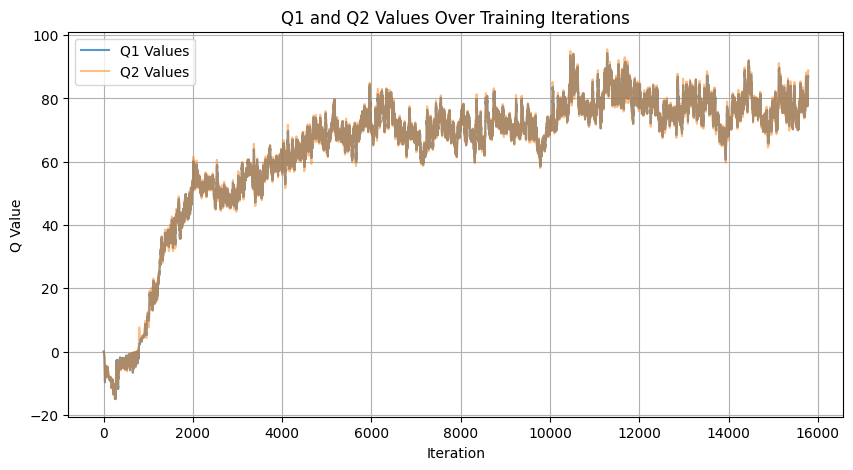

In [28]:
td3_agent.plot_q_values()

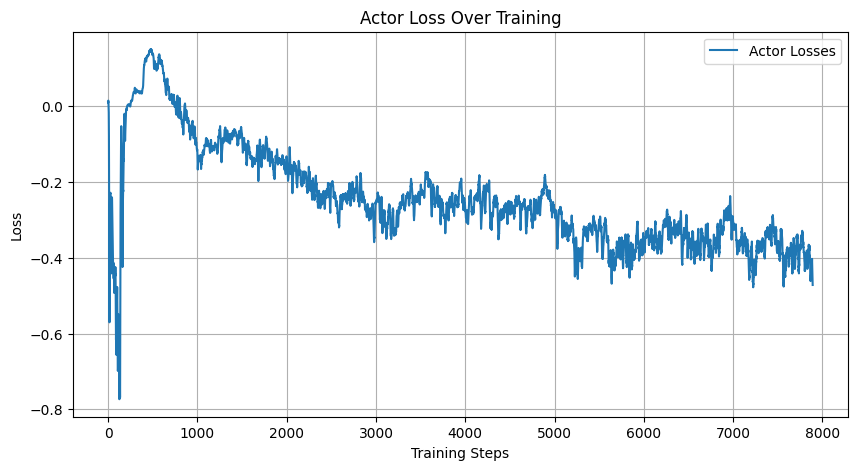

In [29]:
td3_agent.plot_actor_losses()

In [40]:
def test_policy(td3_agent, test_data, initial_investment=1000):
    # Assuming test_data is a DataFrame and has been preprocessed similarly to train_data
    # scaler = td3_agent.env.scaler  # Assuming scaler is stored in the environment or somewhere accessible
    processed_test_data = pd.DataFrame(scaler.fit_transform(test_data.set_index('date')), columns= selected_features[:-1])

    env = TradingEnv(processed_test_data, scaler)  # Create a test environment with the processed test data
    state = env.reset()
    done = False
    current_investment = initial_investment
    portfolio_value = [current_investment]

    buy_signals, sell_signals = [], []

    for t in range(len(processed_test_data)):
        action = td3_agent.select_action(np.array(state))
        next_state, reward, done, info = env.step(action)

        # Update portfolio value based on action taken and reward received
        current_investment += reward
        portfolio_value.append(current_investment)

        if action == 1:  # Assuming '1' means buy
            buy_signals.append(t)
        elif action == 2:  # Assuming '2' means sell
            sell_signals.append(t)

        state = next_state if not done else env.reset()

    # Calculate profit percentage and Sharpe ratio
    profit_percent = ((portfolio_value[-1] - initial_investment) / initial_investment) * 100
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)

    # Plotting the stock price and trading signals
    plt.figure(figsize=(14, 7))
    plt.plot(processed_test_data['close_t-0'], label='Close Price', color='gray')
    plt.scatter(buy_signals, processed_test_data['close_t-0'].iloc[buy_signals], color='green', label='Buy Signal', alpha=0.5, marker='^')
    plt.scatter(sell_signals, processed_test_data['close_t-0'].iloc[sell_signals], color='red', label='Sell Signal', alpha=0.5, marker='v')
    plt.title('Close Price and Trading Signals - TD3 algorithm')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return profit_percent, sharpe_ratio, portfolio_value, current_investment

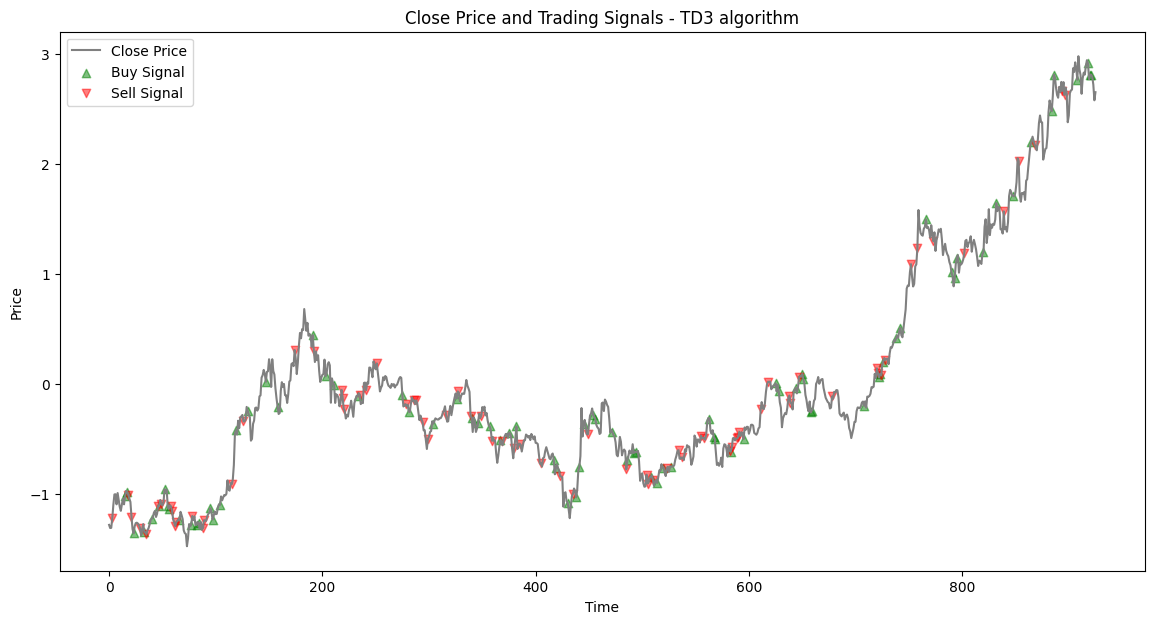

In [42]:
profit, sharpe, pv, ci = test_policy(td3_agent, test_data)

In [46]:
print(profit, sharpe)

623.1489932373366 0.9800673361156909


In [48]:
# 726.6132466186684 0.9918260861064115
# 612.1092432373373 0.9858759799271769
# 623.1489932373366 0.9800673361156909

In [48]:
torch.argmax(td3_agent.actor(torch.FloatTensor(test_data.drop(columns='date').iloc[102]).to(device)))

tensor(2)

In [49]:
# Assuming your models are named actor, critic_1, and critic_2
torch.save(td3_agent.actor.state_dict(), 'models/v5-(20window)/actor.pth')
torch.save(td3_agent.critic_1.state_dict(), 'models/v5-(20window)/critic_1.pth')
torch.save(td3_agent.critic_2.state_dict(), 'models/v5-(20window)/critic_2.pth')

In [32]:
test_data

,open_t-0,open_t-1,open_t-2,open_t-3,open_t-4,open_t-5,open_t-6,open_t-7,open_t-8,open_t-9,...,close_t-3,close_t-4,close_t-5,close_t-6,close_t-7,close_t-8,close_t-9,SMA_10,EMA_10,date
68995,3534.20,3529.95,3524.45,3528.80,3523.95,3525.05,3526.45,3528.80,3528.75,3528.80,...,3525.00,3528.55,3523.95,3525.00,3526.25,3528.80,3528.75,3526.010,3525.412407,2023-10-03 09:15:00+05:30
68996,3519.40,3534.20,3529.95,3524.45,3528.80,3523.95,3525.05,3526.45,3528.80,3528.75,...,3529.40,3525.00,3528.55,3523.95,3525.00,3526.25,3528.80,3524.220,3522.764697,2023-10-03 09:16:00+05:30
68997,3510.00,3519.40,3534.20,3529.95,3524.45,3528.80,3523.95,3525.05,3526.45,3528.80,...,3525.00,3529.40,3525.00,3528.55,3523.95,3525.00,3526.25,3523.175,3521.962025,2023-10-03 09:17:00+05:30
68998,3518.75,3510.00,3519.40,3534.20,3529.95,3524.45,3528.80,3523.95,3525.05,3526.45,...,3519.40,3525.00,3529.40,3525.00,3528.55,3523.95,3525.00,3522.650,3521.787111,2023-10-03 09:18:00+05:30
68999,3521.15,3518.75,3510.00,3519.40,3534.20,3529.95,3524.45,3528.80,3523.95,3525.05,...,3510.85,3519.40,3525.00,3529.40,3525.00,3528.55,3523.95,3522.285,3521.707636,2023-10-03 09:19:00+05:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69090,3489.10,3486.00,3489.50,3488.60,3487.50,3488.10,3489.60,3491.60,3491.90,3488.25,...,3489.25,3488.40,3487.15,3486.65,3489.60,3491.60,3490.35,3489.045,3489.755079,2023-10-03 10:50:00+05:30
69091,3492.55,3489.10,3486.00,3489.50,3488.60,3487.50,3488.10,3489.60,3491.60,3491.90,...,3486.00,3489.25,3488.40,3487.15,3486.65,3489.60,3491.60,3488.930,3489.654156,2023-10-03 10:51:00+05:30
69092,3489.20,3492.55,3489.10,3486.00,3489.50,3488.60,3487.50,3488.10,3489.60,3491.60,...,3488.90,3486.00,3489.25,3488.40,3487.15,3486.65,3489.60,3488.705,3489.598855,2023-10-03 10:52:00+05:30
69093,3489.35,3489.20,3492.55,3489.10,3486.00,3489.50,3488.60,3487.50,3488.10,3489.60,...,3492.55,3488.90,3486.00,3489.25,3488.40,3487.15,3486.65,3488.550,3489.317245,2023-10-03 10:53:00+05:30
